# Probability and land-use

The introduction of a threshhold value for beach-litter density by the EU and the reasons for the application of that threshhold mark a change in the importance and use of beach litter data. Prior to the establishment of a threshold the primary use of beach-litter data was to _educate_ the public and in some instances define a link with mortality and mobidity of marine species. At present beach-litter survey results are also considered on the numerical distance from a stated goal. That goal is defined in __pieces of trash for every 100 m__. The goal is based on the principal of precaution, that means we are unsure of the long term consequences of exposure to plastics and it would be best to minimize exposure if possible.[EU Threshold Value for Macro Litter on Coastlines](https://mcc.jrc.ec.europa.eu/main/dev.py?N=41&O=454)

With the announcement of a threshhold value __there was no subsequent recomendation for changing the methods of sampling__. Consequently, this environmental assessment relies on the recorded observations of volunteers following a standard protocol. According to the journal [Nature](https://www.nature.com/articles/s41893-019-0390-3), programs that include the involvement of citizens in scientific research and/or knowledge production, can complement and ultimately improve the Sustainale Development Goals (SDG) reporting process. Beach litter applies specifically to SDG 14, __the target of achieving substantial reductions in marine pollution__. 

## Motivation

The preceding sections demonstrate that there is a relationship between the enivironmental conditions (land-use) and the amount and types of objects found on the shoreline of Swiss rivers and lakes. However, a positive or negative correlation is only an indicator of the nature of a relationship. If we want to know to what degree we are more likely to find an object under one object or another under different conditions then further analysis must be conducted. As long as the test is used as an indicator it may help define more fruitfull avenues of inquiry.


### Proposition

If an object is positively correlated to a land-use attribute then we should expect to find more of that object when a survey is conducted at locations where that attribute is the most dominant. For example, given that cigarette end are positively correlated to buildings and urbanization we should expect to find more cigarette ends at locations that are primarily urban. Furthermore, we should expect to find less cigarette ends at locations where there are less buildings and more undefined land use, see section three correlation table.

In [1]:
%load_ext watermark
# sys, file and nav packages:
import datetime as dt
import typing

# math packages:
import pandas as pd
import numpy as np
from scipy.stats import beta

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown as md
from IPython.display import display
from myst_nb import glue


def count_nk_bin(data, locations, agg={"k":"sum","n":"sum"}):
    
    return data.loc[locations].agg(agg)

def retrieve_locations_by_bin(data, value="use", columns=["use", "binned"], use="Fels"):
    d = data[data[value] == use]
    d = d.groupby(columns, as_index=False, dropna=False).location.unique()
    return d.dropna()

def collect_odds_frequency(data):
    data["odds"] = data["k"]/(data["n"] - data["k"])
    data["frequency"] = data["k"]/data["n"]
    
    return data

def collect_bin_data(tested, xtest, value="use"):
    use = xtest[value].unique()
    binned = xtest.binned.unique()
    locations = xtest.location.values
    
    bins = []
    
    for i, anarray in enumerate(locations):
        
        a_count = count_nk_bin(tested, anarray)
        a_count[value] = use[0]
        a_count["binned"] = binned[i]
        bins.append(a_count)
    return bins

def n_and_k_for_a_set_of_landuse_data(tested, binned_land_use_data, value="use", value_vars=["use", "binned"]):
    
    binned = []
    for use in binned_land_use_data[value].unique():
        locations_by_bin = retrieve_locations_by_bin(binned_land_use_data, columns=value_vars, value=value, use=use)
        bin_totals = collect_bin_data(tested, locations_by_bin, value=value)
        
        binned += bin_totals
        
        
    df = pd.DataFrame(binned)
    df = df.groupby(value_vars, as_index=False).agg({"k":"sum","n":"sum"})
    return df

# survey data:
dfBeaches = pd.read_csv("resources/beaches.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('location', inplace=True)

# set the index of to codes
dfCodes.set_index("code", inplace=True)

# code description map
code_d_map = dfCodes.description.copy()

# shorten the descriptions of two codes
code_d_map.loc["G38"] = "sheeting for protecting large cargo items"
code_d_map.loc["G73"] = "Foamed items & pieces (non packaging/insulation)"

# code material map
code_m_map = dfCodes.material

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF; text-align:right'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_data = {'selector': 'td', 'props': 'padding: 6px;'}
table_caption = {'selector': 'caption', 'props': 'font-size: 14px; font-style: italic; caption-side: bottom; text-align: left; margin-top: 10px'}
table_css_styles = [even_rows, odd_rows, table_font, header_row, table_caption]

pdtype = pd.core.frame.DataFrame
pstype = pd.core.series.Series

cmap = sns.diverging_palette(230, 20, as_cmap=True)

df = pd.read_csv('resources/surveys_iqaasl.csv')

# the lakes of interest
# collection points would be a good
# label. This is how they are considered in the model
# these locations serve as the endpoint for many 
# small rivers
collection_points = [
    'zurichsee',
    'bielersee',
    'neuenburgersee',
    'walensee',
    'vierwaldstattersee',
    'brienzersee',
    'thunersee',
    'lac-leman',
    'lago-maggiore',
    'lago-di-lugano',
    'zugersee'
]

# the data-frame of survey results to be considered
df = df[df.feature.isin(collection_points)]

# map the location to the name of the lake
wn_map = df[["location", "feature"]].drop_duplicates("location").set_index("location")
wn_map = wn_map["feature"]

In [2]:
# these are the land use values for each hex
# nutuzungsareal and freizeit areal are totaled
# the surface area of these two use cases gets added
# to the total of the land cover surface area
dfln = pd.read_csv("resources/hex-3000m-cleaned/lake-locations-nutuzungsareal.csv")
dflf = pd.read_csv("resources/hex-3000m-cleaned/lake-locations-freizeitareal.csv")

# rename the columns and total the surface are for each component
dflf.rename(columns={"OBJEKTART":"use"}, inplace=True)
dflf = dflf[~dflf.use.isin(['Reben', 'Obstanlage'])].copy()
dflf_t = dflf.groupby(["location", "river_bass", "city", "feature"], as_index=False).surface.sum()
dflf_t["use"] = "recreation"

dfln.rename(columns={"OBJEKTART":"use"}, inplace=True)
dfln = dfln[~dfln.use.isin(['Reben', 'Obstanlage'])].copy()
dfln_t = dfln.groupby(["location", "river_bass", "city", "feature"], as_index=False).surface.sum()
dfln_t["use"] = "infrastructure"

# combine the data frames
rec_inf = pd.concat([dfln_t, dflf_t])
rec_inf = rec_inf[rec_inf.location.isin(collection_points)]

# this is the land cover, the total surface area of the hex is accounted for here
# this includes the surface area of the lake within the hex
# there are portions of the map layer that have no land-use attribute
# to account for this, the total surface area of all labeled sections is 
# substracted from the area of a hex 5845672 m². This attribute is labled 
# undefined
dflc = pd.read_csv("resources/hex-3000m-cleaned/lake-locations-landcover.csv")

# sum the unique land cover values for each location
area_of_a_hex = 5845672
xgr = dflc.groupby(["location", "city", "river_bass","lat", "lon", "feature", "OBJVAL"], as_index=False, dropna=False).surface.sum()

# the sum of all the land cover values for a location
xgrt = xgr.groupby(["location", "city", "river_bass","lat", "lon", "feature"], as_index=False).surface.sum()

# the amount of surface area that is not accounted for 
xgrt["undefined"] = area_of_a_hex - xgrt.surface

# format data frame to join to the other land cover totals
xgrt["OBJVAL"] = "undefined"
xgrt["surface"] = xgrt["undefined"]
xgrt.drop("undefined", inplace=True, axis=1)

# add to other totals
dflcx = pd.concat([xgr, xgrt])

# remove the value of See from the surface area of a hex.
# We are considering the magnitude of land use type in relation
# to the amount of land that is available to be used, not including 
# amount of land that is covered by the lake itself
xsee = xgr[xgr.OBJVAL == "See"][["location", "surface"]]
xsee["hex minus"] = area_of_a_hex - xsee.surface
hex_minus = xsee[["location", "hex minus"]].set_index("location", drop=True)

# map the adjusted surface area to to the land use
# totals and scale the surface column to the adjusted surface area
dflcx["hex minus"] = dflcx.location.apply(lambda x: hex_minus.loc[x, "hex minus"])
# change column name
dflcx.rename(columns={"OBJVAL":"use"}, inplace=True)

# add the land use attributes to the land-cover data
rec_inf["hex minus"] = rec_inf.location.apply(lambda x: hex_minus.loc[x, "hex minus"])

columns = ["location", "river_bass", "city", "feature", "surface", "use", "hex minus"]

agg_land_use = pd.concat([dflcx[columns], rec_inf[columns]])

agg_land_use["scaled"] = agg_land_use.surface/agg_land_use["hex minus"]

# remove See from the data frame
agg_land_use = agg_land_use[agg_land_use.use != "See"]

bind = pd.IntervalIndex.from_tuples([(-1, 0), (0.00000001, .049999), (.05000, .099999), (.10000, .149999),(.15000, .199999), (.2, .2499), (.25, .2999), (.3000, .3499),
        (.35, .3999), (.4000, .449999), (.45, .499999),(.5, .549999), (.55, .5999), (.6000, .6499), (.65, .6999), (.7, .7499), (.75, .7999),
        (.8, .8499), (.85, .8999), (.9, .9499), (.95, 1)])

# bin the scaled column
sbins = pd.cut(agg_land_use.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbins=sbins.cat.rename_categories(np.arange(start=0, stop=21))

agg_land_use["binned"] = sbins

# land use features that get laid on top of the land-cover features
# the distance ot the river intersections and the length of the river
# features in the hexgon
dist_ct = pd.read_csv("resources/hex-3000m-cleaned/river-intersect-length.csv")
dist_dt = dist_ct.groupby("location", as_index=False).agg({"distance":"mean", "length":"sum"})
dist_dt = dist_dt[dist_dt.location.isin(df.location.unique())].copy()
dist_dt = pd.melt(dist_dt, id_vars = "location", value_vars=["length", "distance"])

# min max scale
dist_dt["scaled"] = (dist_dt["value"] - dist_dt["value"].min())/(dist_dt["value"].max() - dist_dt["value"].min())
# bin in groups of 0.05 plus one bin for zero
sbinsr = pd.cut(dist_dt.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbinsr=sbinsr.cat.rename_categories(np.arange(start=0, stop=21))
dist_dt["binned"] = sbinsr

# add the survey area and feature name to the data
rbas_map = df[["location", "river_bassin"]].drop_duplicates(["location", "river_bassin"]).set_index("location")
rbas_map = rbas_map["river_bassin"]
dist_dt["feature"] = dist_dt.location.apply(lambda x: wn_map.loc[x])
dist_dt["river_bass"] = dist_dt.location.apply(lambda x: rbas_map.loc[x])

# the length of the road network in the hex
strasse = pd.read_csv("resources/hex-3000m-cleaned/lake-locations-strasse.csv")
strasse = strasse[strasse.location.isin(df.location.unique())].copy()
stras = strasse.groupby(["location","river_bass", "city", "feature",  ], as_index=False).length.sum()

# min max scale
stras["scaled"] = (stras["length"] - stras["length"].min())/(stras["length"].max() - stras["length"].min())
# bin
sbinsras = pd.cut(stras.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbinsras=sbinsras.cat.rename_categories(np.arange(start=0, stop=21))
stras["binned"] = sbinsras
stras["use"] = "Strasse"

mix_agg = agg_land_use.copy()
mix_agg["binned"] = mix_agg.binned.astype('int')
mix_agg.drop_duplicates(["location", "use"], inplace=True)
mix_agg_scale_key = mix_agg[["location", "river_bass", "feature", "use", "surface", "scaled", "binned"]].set_index("location")
mix_agg_scale_key.rename(columns={"surface":"magnitude"}, inplace=True)
mix_agg_scale_key

mix_dt = dist_dt.copy()
mix_dt["binned"] = mix_dt.binned.astype('int')
mix_dt.drop_duplicates(["location", "variable"], inplace=True)
mix_dt_scale_key = mix_dt[["location", "river_bass", "feature", "variable", "value", "scaled", "binned"]].set_index("location")
mix_dt_scale_key.rename(columns={"variable":"use"}, inplace=True)
mix_dt_scale_key.rename(columns={"value":"magnitude"}, inplace=True)
mix_dt_scale_key

strass_dt_scale_key = stras[["location", "river_bass", "feature", "use", "length", "scaled", "binned"]].copy()
strass_dt_scale_key["binned"] = strass_dt_scale_key.binned.astype(int)
strass_dt_scale_key.rename(columns={"length":"magnitude"}, inplace=True)
strass_dt_scale_key.set_index("location", inplace=True, drop=True)

land_use_keys = pd.concat([strass_dt_scale_key, mix_dt_scale_key, mix_agg_scale_key])
land_use_keys.reset_index(drop=False, inplace=True)
land_use_keys = land_use_keys[land_use_keys.location.isin(df.location.unique())]
lusek_copy = land_use_keys.copy()

## The probability of finding a cigarette end

We test the proposition by constructing a discrete grid approximation of the probability of finding an on object under two different conditions.

1. The probability of finding a cigarette end when the land-use is mostly buildings
2. The probability of finding a cigarette end when the land-use is mostly undefined

There five steps to constructing a grid approximation:

1. Discretize the parameter space if it is not already discrete.
2. Compute prior and likelihood at each “grid point” in the (discretized) parameter space.
3. Compute (kernel of) posterior as prior ⋅
4. likelihood at each “grid point”.
5. Normalize to get posterior, if desired.

For this manuscript we are not detailing the construction of the grid. Note that the same data in section three is used here. If you would like to know how this is done in detail follow the one the links. Users of _R_ should select _Krushke_ or _Bayes rules_, python users should follow _Think Bayes_. [Krushke](https://rpruim.github.io/Kruschke-Notes/bayes-rule-and-the-grid-method.html), [Bayes rules](https://www.bayesrulesbook.com/chapter-6.html), [Think Bayes](https://www.bayesrulesbook.com/chapter-6.html)

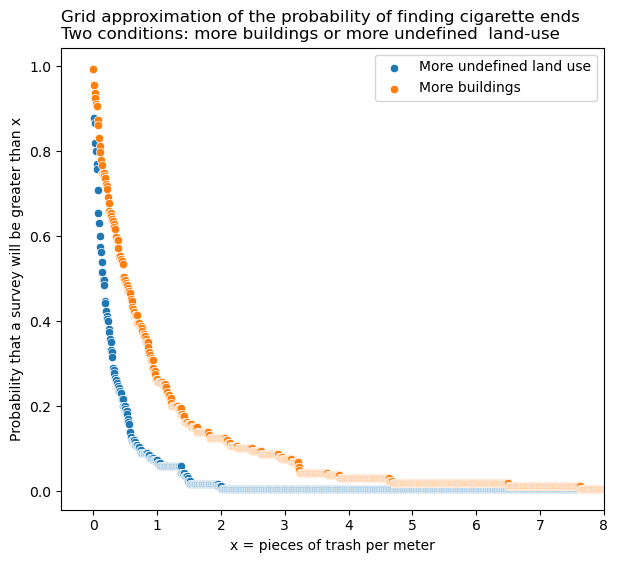

In [3]:
cigs = df[df.code == "G27"].copy()
sied = lusek_copy[lusek_copy.use == "Siedl"].pivot(columns="use", index="location", values="magnitude")
wald = lusek_copy[lusek_copy.use == "undefined"].pivot(columns="use", index="location", values="magnitude")

cigs = cigs.merge(sied, left_on="location", right_index=True, validate="many_to_one")
cigs = cigs.merge(wald, left_on="location", right_index=True, validate="many_to_one")
cigs = cigs[["loc_date", "code", "pcs_m", "Siedl", "undefined"]]

med_wald = cigs.undefined.median()
med_siedl = cigs.Siedl.median()

more_city = cigs[cigs.Siedl > med_siedl]
more_woods = cigs[cigs.undefined > med_wald]

xrange = np.arange(0, 10.01, step=.01)
def when_k_is_zero_or_equal_to_n(k, n):
    if k == n:
        return (k, n-k+1)
    elif k == 0:
        return (k+1, n-k+1)
    else:
        return (k, n-k)

def n_k_per_set(data, xrange):
    
    d = data.pcs_m.values
    kn =[beta(*when_k_is_zero_or_equal_to_n((d >= x).sum(), len(d))).mean() for x in xrange]
    
        
    return kn

p_woods = n_k_per_set(more_woods, xrange)
p_siedl = n_k_per_set(more_city, xrange)

combined = pd.DataFrame({"undefined":p_woods, "city":p_siedl}, index=xrange)

fig, ax = plt.subplots(figsize=(7,6))


sns.scatterplot(x=xrange, y=p_woods, label="More undefined land use")
sns.scatterplot(x=xrange, y=p_siedl, label="More buildings")

ax.set_xlim(-.5, 8)

ax.set_ylabel("Probability that a survey will be greater than x")
ax.set_xlabel("x = pieces of trash per meter")
ax.set_title("Grid approximation of the probability of finding cigarette ends\nTwo conditions: more buildings or more undefined  land-use", loc="left")

plt.show()

### Interpretation

Locations with a greater percentage of land attributed to buildings have a higher probability of returning survey results with more cigarette ends. The difference is greates on the range of $\approx$ 0.2 pcs/m to 5 pcs/m.

In [4]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

*analyst at hammerdirt*
"""

md(my_block)



This script updated 09/08/2023 in Biel, CH

> ❤️ what you do everyday

*analyst at hammerdirt*


In [5]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/landuse.git

Git branch: main

seaborn   : 0.12.2
numpy     : 1.24.2
pandas    : 2.0.0
matplotlib: 3.7.1

